# Dense Sentiment Classifier

In this notebook, we build a dense neural net to classify IMDB movie reviews by their sentiment.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/dense_sentiment_classifier.ipynb)

#### Load dependencies

In [87]:
import keras
from keras.datasets import imdb # new!
from keras.preprocessing.sequence import pad_sequences #new!
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding # new!
from keras.callbacks import ModelCheckpoint # new!
import os # new!
from sklearn.metrics import roc_auc_score, roc_curve # new!
import pandas as pd
import matplotlib.pyplot as plt # new!
%matplotlib inline

#### Set hyperparameters

In [88]:
# output directory name:
output_dir = 'model_output/dense'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
n_words_to_skip = 50 # ditto
max_review_length = 100
pad_type = trunc_type = 'pre'

# neural network architecture:
n_dense = 64
dropout = 0.5

#### Load data

For a given data set:

* the Keras text utilities [here](https://keras.io/preprocessing/text/) quickly preprocess natural language and convert it into an index
* the `keras.preprocessing.text.Tokenizer` class may do everything you need in one line:
    * tokenize into words or characters
    * `num_words`: maximum unique tokens
    * filter out punctuation
    * lower case
    * convert words to an integer index

In [89]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words,
                                                        skip_top=n_words_to_skip)

**N.B.**: If you're using Google Colab and the above line of code throws this error:

[ValueError: Object arrays cannot be loaded when allow_pickle=False](https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa)

As of May 24th, 2019 you can resolve this error by executing `!pip install numpy==1.16.2` and restarting the runtime (by default, Colab uses a later version of NumPy -- 1.16.3 -- that causes the error).

In [90]:
x_train[0:6] # 0 reserved for padding; 1 would be starting character; 2 is unknown; 3 is most common word, etc.

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [91]:
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [92]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

In [93]:
len(x_train), len(x_valid)

(25000, 25000)

#### Restoring words from index

In [94]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

In [95]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [96]:
index_word = {v:k for k,v in word_index.items()}

In [97]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [98]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [99]:
(all_x_train,_),(all_x_valid,_) = imdb.load_data()

In [100]:
' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### Preprocess data

In [101]:
x_train = pad_sequences(x_train, maxlen=max_review_length,
                        padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length,
                        padding=pad_type, truncating=trunc_type, value=0)

In [102]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [103]:
for x in x_train[0:6]:
    print(len(x))

100
100
100
100
100
100


In [104]:
' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [105]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

#### Design neural network architecture

In [106]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes

In [133]:
model.summary() # so many parameters!

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189,189 (8.35 MB)

 Trainable params: 729,729 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,459,460 (5.57 MB)

In [108]:
# embedding layer dimensions and parameters:
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [109]:
# ...flatten:
max_review_length, n_dim, n_dim*max_review_length

(100, 64, 6400)

In [110]:
# ...dense:
n_dense, n_dim*max_review_length*n_dense + n_dense # weights + biases

(64, 409664)

In [111]:
# ...and output:
n_dense + 1

65

#### Configure model

In [112]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [113]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.keras")

In [114]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [115]:
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=[modelcheckpoint])

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5987 - loss: 0.6422 - val_accuracy: 0.8358 - val_loss: 0.3694
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8749 - loss: 0.3024 - val_accuracy: 0.8415 - val_loss: 0.3555
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9610 - loss: 0.1263 - val_accuracy: 0.8310 - val_loss: 0.4229
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9960 - loss: 0.0300 - val_accuracy: 0.8282 - val_loss: 0.5130


#### Evaluate

In [116]:
model.load_weights(output_dir+"/weights.02.keras") # NOT zero-indexed

In [117]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [118]:
len(y_hat)

25000

In [119]:
y_hat[0]

array([0.37459937], dtype=float32)

In [120]:
y_valid[0]

np.int64(0)

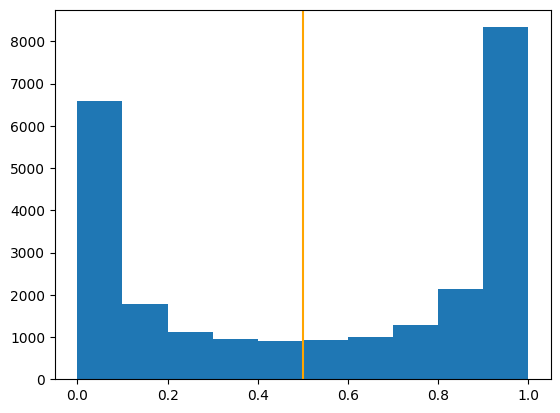

In [121]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [122]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [123]:
"{:0.2f}".format(pct_auc)

'92.73'

In [124]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [125]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [126]:
ydf.head(10)

,y_hat,y
0,0.374599,0
1,0.976653,1
2,0.892793,1
3,0.644199,0
4,0.993449,1
5,0.643688,1
6,0.956244,1
7,0.020719,0
8,0.776541,0
9,0.802280,1


In [127]:
' '.join(index_word[id] for id in all_x_valid[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [128]:
' '.join(index_word[id] for id in all_x_valid[6])

"START originally supposed to be just a part of a huge epic the year 1905 depicting the revolution of 1905 potemkin is the story of the mutiny of the crew of the potemkin in odessa harbor the film opens with the crew protesting meat and the captain ordering the execution of the an uprising takes place during which the revolutionary leader is killed this crewman is taken to the shore to lie in state when the townspeople gather on a huge flight of steps overlooking the harbor czarist troops appear and march down the steps breaking up the crowd a naval squadron is sent to retake the potemkin but at the moment when the ships come into range their crews allow the to pass through eisenstein's non historically accurate ending is open ended thus indicating that this was the seed of the later bolshevik revolution that would bloom in russia the film is broken into five parts men and maggots drama on the an appeal from the dead the odessa steps and meeting the squadron br br eisenstein was a revo

In [129]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
75,0.950398,0
152,0.954533,0
256,0.960092,0
386,0.968738,0
495,0.940869,0
547,0.970618,0
555,0.938311,0
558,0.949070,0
593,0.931319,0
680,0.907310,0


In [130]:
' '.join(index_word[id] for id in all_x_valid[386])

"START wow another kevin costner hero movie postman tin cup waterworld bodyguard wyatt earp robin hood even that baseball movie seems like he makes movies specifically to be the center of attention the characters are almost always the same the heroics the flaws the greatness the fall the redemption yup within the 1st 5 minutes of the movie we're all supposed to be in awe of his character and it builds up more and more from there br br and this time the story story is just a collage of different movies you don't need a spoiler you've seen this movie several times though it had different titles you'll know what will happen way before it happens this is like mixing an officer and a gentleman with but both are easily better movies watch to see how this kind of movie should be made and also to see how an good but slightly underrated actor russell plays the hero"

In [131]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
45,0.061405,1
101,0.021963,1
300,0.026041,1
667,0.029930,1
973,0.081417,1
1192,0.055813,1
1229,0.061722,1
1361,0.078151,1
1627,0.032026,1
1837,0.071730,1


In [132]:
' '.join(index_word[id] for id in all_x_valid[224])

"START finally a true horror movie this is the first time in years that i had to cover my eyes i am a horror buff and i recommend this movie but it is quite gory i am not a big wrestling fan but kane really pulled the whole monster thing off i have to admit that i didn't want to see this movie my 17 year old dragged me to it but am very glad i did during and after the movie i was looking over my shoulder i have to agree with others about the whole remake horror movies enough is enough i think that is why this movie is getting some good reviews it is a refreshing change and takes you back to the texas chainsaw first one michael myers and jason and no cgi crap"